In [1]:
!pip install networkx

In [2]:
#importing libraries
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
from qiskit import *
from qiskit.quantum_info import Statevector
import networkx as nx
from qiskit import Aer, execute, QuantumCircuit
from docplex import *
# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    edge_labels = nx.get_edge_attributes(G, 'weight')
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# **CHECKING MAXCUT**

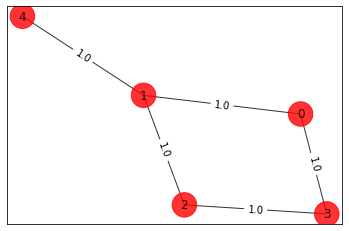

In [3]:
#CREATING A GRAPH
G= nx.Graph()
#add nodes to graph
n=5
G.add_nodes_from(range(n))
#add weights to graph nodes 
# add edges: tuple is (i,j,weight) where (i,j) is the edge
edges= [(0,1,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0),(1,4,1.0)]
G.add_weighted_edges_from(edges)
#plot
plot_result(G,[0]*n)

# Example: Modeling MaxCut with DOcplex

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j)
$$

In [4]:
from docplex.mp.model import Model
mdl=Model('MaxCut')
#creating binary variables x0,x1,x2,x3
x=mdl.binary_var_list('x{}'.format(i) for i in range(n)) #n is defined in the previous part
#creating the cost function and attqaching it to the model
objective= mdl.sum([w*(x[i]+x[j]-2*x[i]*x[j]) for (i,j,w)in edges]) #edges is defined in the previous part
#maximizing the function
mdl.maximize(objective)
#printing the problem
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 2 x0 + 3 x1 + 2 x2 + 2 x3 + x4 [ - 2 x0*x1 - 2 x0*x3 - 2 x1*x2 - 2 x1*x4
 - 2 x2*x3 ];
 
subject to {

}


# Example: Adding a Constraint

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j) \\
\text{subject to:} \sum_{i=0}^{n-1} x_i = b
$$

In [5]:
b=2
mdl.add_constraint(sum(x)==b)
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 2 x0 + 3 x1 + 2 x2 + 2 x3 + x4 [ - 2 x0*x1 - 2 x0*x3 - 2 x1*x2 - 2 x1*x4
 - 2 x2*x3 ];
 
subject to {
 x0 + x1 + x2 + x3 + x4 == 2;

}


# 1. Solving the quadritic program with DOcplex



C:\Users\soura\anaconda3\lib\site-packages\qiskit\optimization\__init__.py:92: DeprecationWarning: The package qiskit.optimization is deprecated. It was moved/refactored to qiskit_optimization (pip install qiskit-optimization). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('optimization', 'qiskit_optimization', 'qiskit-optimization')


optimal function value: 5.0
optimal value: [ 0.  1. -0.  1. -0.]
status: SUCCESS


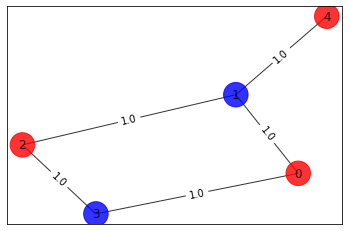

In [6]:

from qiskit.optimization import QuadraticProgram
from qiskit.optimization.algorithms import CplexOptimizer
#created a quadratic program
qp=QuadraticProgram()
#we have created the quadratic model via Docplex, now we have imported the model into the quadritic program
qp.from_docplex(mdl)
#now using CPLEX we are solving the problem
cplex = CplexOptimizer()
result=cplex.solve(qp)
#printing the result and plotting it
print(result)
plot_result(G, result.x)

# 2. Optimization via Ising Hamiltonian


## Conversion to QUBO

Qiskit's Optimization module provides converters for Quadratic Programs:

# REFERENCE
https://qiskit.org/documentation/tutorials/optimization/2_converters_for_quadratic_programs.html
https://qiskit.org/documentation/tutorials/optimization/1_quadratic_program.html

PENALTY -- https://web.stanford.edu/group/sisl/k12/optimization/MO-unit5-pdfs/5.6penaltyfunctions.pdf

In [7]:
from qiskit.optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints by adding slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo    # combines the previous three converters
)

## Linear Equality Constraint to Quadratic Penalty Term

In [8]:

lin_cons_2_qua_penalty = LinearEqualityToPenalty(penalty=1)
qp_without_constraint= lin_cons_2_qua_penalty.convert(qp) 
qp_without_constraint

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Maximize
 obj: 6 x0 + 7 x1 + 6 x2 + 6 x3 + 5 x4 + [ - 2 x0^2 - 8 x0*x1 - 4 x0*x2
      - 8 x0*x3 - 4 x0*x4 - 2 x1^2 - 8 x1*x2 - 4 x1*x3 - 8 x1*x4 - 2 x2^2
      - 8 x2*x3 - 4 x2*x4 - 2 x3^2 - 4 x3*x4 - 2 x4^2 ]/2 -4
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End

optimal function value: 5.0
optimal value: [0. 1. 0. 1. 0.]
status: SUCCESS


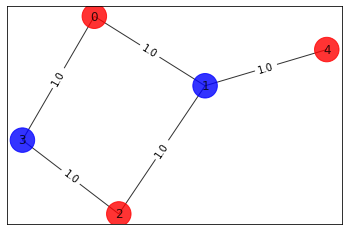

In [9]:
#solving the penalty added contraintless equation with cplex
result = cplex.solve(qp_without_constraint)
print(result)
plot_result(G,result.x)

## Mapping of QUBO to Ising Hamiltonian

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

1. Substitute<br>
$x_i = (1 - z_i)/2,$<br>
where $z_i \in \{-1, +1\}$.
<br>

2. Replace<br>
$z_i z_j = \sigma_Z^i \otimes \sigma_Z^j$, and<br>
$z_i = \sigma_Z^i$,<br>
where $\sigma_Z^i$ denotes the Pauli Z-matrix $\left(\begin{array}{cc}1&0\\0&-1\end{array}\right)$ on the $i$-th qubit.

## From QUBO to Finding Hamiltonian Groundstates

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

which has been mapped to an Ising Hamiltonian:
$$
H = \sum_{i,j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i + \tilde{c}
$$

Finding the groundstate of $H$ is equivalent to solving the QUBO:

$$
\min_{|\psi\rangle} \langle \psi |H| \psi \rangle
$$

<br>

<b>Remark:</b> $H$ is diagonal, and thus, all computational basis states are eigenstates.

# REFERENCES
https://qiskit.org/documentation/tutorials/optimization/3_minimum_eigen_optimizer.html

In [10]:
#converting the quadrititic binary unconstrined (as there is no constraint (see above) equation to ising hamiltoninan 
H,offset=qp_without_constraint.to_ising() 
print('offset=',offset)
print('\n')
print('H=',H)

offset= -1.0


H= SummedOp([
  -0.5 * IIIIZ,
  -0.5 * IIIZI,
  -0.5 * IZIII,
  -0.5 * IIZII,
  -0.5 * ZIIII,
  IIIZZ,
  0.5 * IIZIZ,
  IIZZI,
  IZIIZ,
  0.5 * IZIZI,
  IZZII,
  0.5 * ZIIIZ,
  ZIIZI,
  0.5 * ZIZII,
  0.5 * ZZIII
])


C:\Users\soura\anaconda3\lib\site-packages\qiskit\aqua\operators\operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


# PLOTTING the diagonal elements of the hamiltonian

In [11]:
H_matrix = np.real(H.to_matrix())  #converts the hamiltonian to matrix form
print('dim(H):', H_matrix.shape)  #printing the dimension of the matrix
print(H_matrix)                   # printing the matrix
print(H_matrix.diagonal())        # prining the diagonal of the matrix
print(min(H_matrix.diagonal()))   # printing the minimum element of the diagonal
# finding the indices or indexes of the diagonal of the matrix where the minimum element lies
dia_min_indices = list(np.where(H_matrix.diagonal()==min(H_matrix.diagonal())))[0]
print(dia_min_indexes)
#plotting the diagonal elements by a bar graph
plt.figure(figsize=(12, 5))
plt.bar(range(2**n),H_matrix.diagonal())
plt.bar(dia_min_indices,H_matrix.diagonal()[dia_min_indices],color='g')#plotting minimum indices in green
plt.xticks(range(2**n),['('+str(i)+'){0:05b}'.format(i) for i in range(2**n)],rotation=90,fontsize=14)
plt.yticks(fontsize=14)
plt.show()

dim(H): (32, 32)
[[ 5.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2.  0.  0.]
 [ 0.  0.  0. ...  0.  3.  0.]
 [ 0.  0.  0. ...  0.  0. 10.]]
[ 5.  0. -1. -2.  0. -3. -2. -1.  0. -1. -4. -1. -1.  0. -1.  4.  1. -2.
 -1.  0. -2. -3.  0.  3. -2. -1. -2.  3. -1.  2.  3. 10.]
-4.0


NameError: name 'dia_min_indexes' is not defined

## Variational Quantum Eigensolver (VQE)

Replace minimization over all $|\psi\rangle$ by minimization over a parametrized subset $|\psi(\theta)\rangle$:
<br>

$$
\min_{\theta} \langle \psi(\theta) |H| \psi(\theta) \rangle
$$

## From Previous Session: VQE with `RealAmplitudes` Circuit